# Task 2. Examine your network

Examine the network and analyze how it processes the data.
Read in the trained network as the first step and print the model.

This should show you the structure of the network and the name of each layer.

In [1]:
import sys
import math
import nbimporter
import Task1AE as Note1AE
import Task1FG as Note1FG

import torch
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt


In [2]:
# 1. init network from the last saved
network = Note1FG.load_network_state(Note1AE.NeuralNetwork())
print(network)

NeuralNetwork(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


## A. Analyze the first layer

Get the weights of the first layer.

When accessing a network, use the name of the layer as specified in the model printout. In this case, the name should be conv1. You access the weights using model.conv1.weight. The result is a tensor that should have the shape [10, 1, 5, 5]. That means there are ten filters, each 5x5 in size. To access the ith 5x5 filter, use weights[i, 0]. Print the filter weights and their shape.

Visualize the ten filters using pyplot.

You can use the pyplot functions figure, subplot, and imshow to make a 3x4 grid of figures such as the image below. If you set xticks and yticks to the empty list [], it will give you a cleaner plot.


10 of 5X5 filter: [[ 0.07151064  0.03299135  0.01118369  0.22731791  0.2742086 ]
 [ 0.10299252  0.36971265  0.24683248  0.21536364  0.11025143]
 [ 0.1384765   0.02264798  0.09850367 -0.06719237 -0.02803132]
 [-0.14565764 -0.1352678  -0.14507344 -0.22973776 -0.00436289]
 [-0.32415846 -0.3704104  -0.35031086 -0.19700205 -0.06781409]]
shape (5, 5)

10 of 5X5 filter: [[-0.26664552  0.04358506 -0.26644775  0.02435745  0.04614886]
 [-0.12241465  0.11588793  0.01802011  0.20217066  0.09204762]
 [-0.09270994  0.02806713 -0.09396666  0.10172269  0.20570655]
 [ 0.08011881 -0.07356349  0.0551278   0.02592128  0.256852  ]
 [-0.21465756 -0.25933322 -0.22578229 -0.2721377   0.25956988]]
shape (5, 5)

10 of 5X5 filter: [[ 0.2834441   0.1690834   0.08919574  0.03390388  0.17794189]
 [-0.19403727 -0.05212707 -0.14090072 -0.02569456 -0.22406192]
 [-0.017825   -0.05321601  0.16775218 -0.14859876 -0.27687442]
 [-0.1757175   0.12305441  0.11955246  0.32648867 -0.1665626 ]
 [-0.24165092 -0.2284648  -0.1007

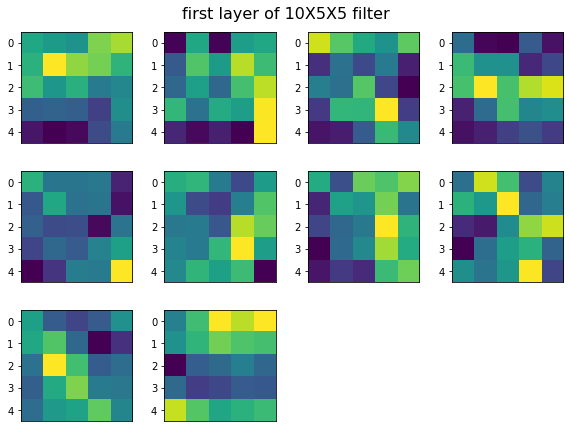

In [3]:
figure = plt.figure(figsize=(8, 8))
weights = network.conv1.weight

for i in range(10):
    # 1. Prepare grid
    plt.subplot(4, 4, i+1)
    plt.tight_layout()
   
    # 2. make sure the shape is 5X5 before doing imshow
    filter_matrix = weights[i][0].detach().numpy()
    print("\n10 of 5X5 filter:", filter_matrix)
    print("shape", filter_matrix.shape)

    
    # 3. show
    figure.suptitle("first layer of 10X5X5 filter", fontsize=16)
    plt.imshow(filter_matrix, interpolation="none")
    plt.xticks([])

In [4]:
weights[i][0].detach().numpy().shape

(5, 5)

## B. Show the effect of the filters

Use OpenCV's filter2D function to apply the 10 filters to the first training example image.

Generate a plot of the 10 filtered images such as the one below. When working with the weights, you will need to tell pyTorch it does not need to calculate gradients. 


torch.Size([1, 28, 28])
torch.Size([28, 28])


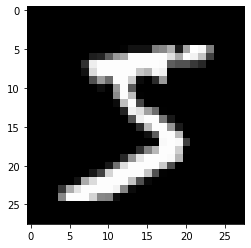

In [5]:
# 1. get the first training image (1X28X28) 
train_loader = Note1AE.get_loader(is_train=True)
img = Note1FG.load_firstN_data(train_loader, 1)[0]
print(img.shape)
print(img[0].shape)
plt.imshow(img[0], cmap='gray', interpolation='none')



In [6]:
# 2. apply first conv filter to the image
with torch.no_grad():
    network.eval()
    output = network.conv1(img)
    print(output.shape)

torch.Size([10, 24, 24])


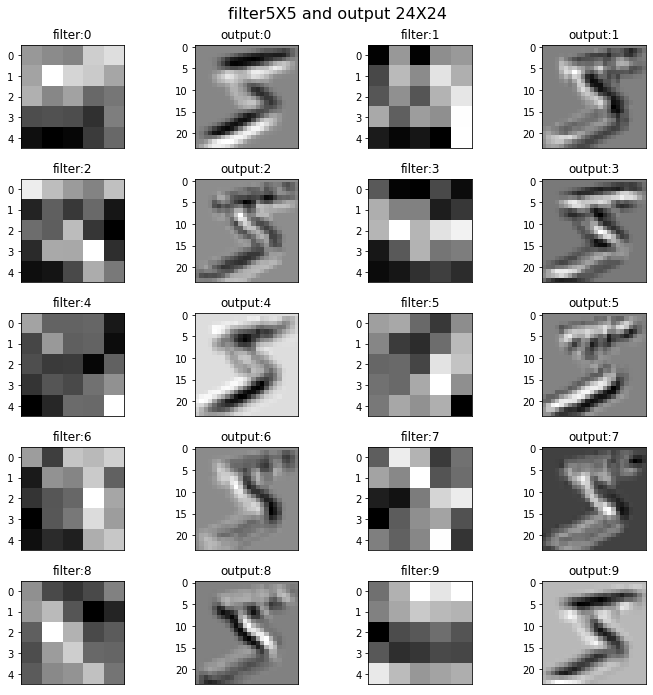

In [7]:
# 3. plot
figure = plt.figure(figsize=(10, 10))
img_index = 0
plot_index = 1 # total 20 plots
figure.suptitle("filter5X5 and output 24X24", fontsize=16)

 
while(img_index < 10):
    # 1. draw filter
    plt.subplot(5, 4, plot_index)
    plt.tight_layout()
    filter_matrix = weights[img_index][0].detach().numpy()
    plt.imshow(filter_matrix, cmap = 'gray', interpolation="none")
    plt.title("filter:%d" %(img_index))
    plt.xticks([])
    
    plot_index+=1
    
    # 2. draw output after filter
    plt.subplot(5, 4, plot_index)
    plt.tight_layout()
    output_matrix = output[img_index]
    plt.title("output:%d" %(img_index))

    plt.imshow(output_matrix, cmap='gray',interpolation="none")
    plt.xticks([])
    
    img_index +=1
    plot_index+=1
    


In [8]:
## question:

# in the filter:
# what does the filter mean? how can we tell what filter is doing what?

# in the feature map (output):
#the feature that is present is light or black ? it should be close to 1 ?
# In your report, include the plot and note whether the results make sense given the filters.



# 3. Build a truncated model
Build a new model using only the first two convolutional layers. A simple way to do this is to create a subclass of the Net class you created where the forward function is only the first two steps.

In [9]:
# 1. Create a Submodel object 
class Submodel(Note1AE.NeuralNetwork):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward( self, x ):
        
        # relu on max pooled results of conv1
        x = F.relu( F.max_pool2d( self.conv1(x), 2 ) ) 
        # relu on max pooled results of dropout of conv2
        x = F.relu( F.max_pool2d( self.conv2_drop( self.conv2(x)), 2 ) ) 
        return x

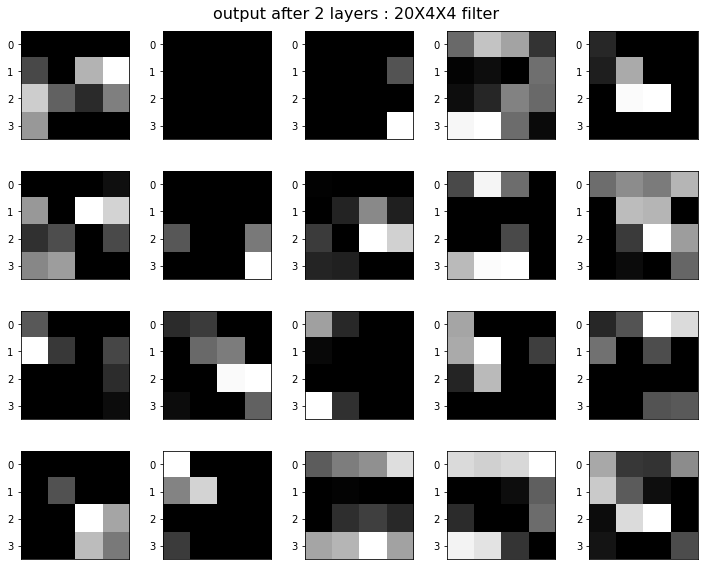

In [10]:
# 2. load the state dictionary you read from the file. 
subnetwork = Submodel()
Note1FG.load_network_state(subnetwork)
outputSub = Note1FG.run_network(subnetwork, img)


# 3. plot the ouput after runnint the sub network
size_r= 10
size_c = 10

figure = plt.figure(figsize=(size_r, size_c))
figure.suptitle("output after 2 layers : 20X4X4 filter", fontsize=16)

for i in range(len(outputSub)):
    row_col = math.ceil(math.sqrt(len(outputSub)))
    # - set the fig
    plt.subplot(row_col, row_col, i+1)
    plt.tight_layout()
    plt.imshow(outputSub[i], cmap = 'gray', interpolation='none')

    # - remove x, y values
    plt.xticks([])

In [11]:
# Question: how to make sense of this ouput?

Try modifying the forward function so it returns after only the first layer. Double-check that these look like filtered versions of the input image.

In [12]:
# 1. Create a Submodel 1 layer object 
class Submodel1(Note1AE.NeuralNetwork):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward( self, x ):
        
        # relu on max pooled results of conv1
        x = F.relu( F.max_pool2d( self.conv1(x), 2 ) ) 
        return x

torch.Size([10, 12, 12])


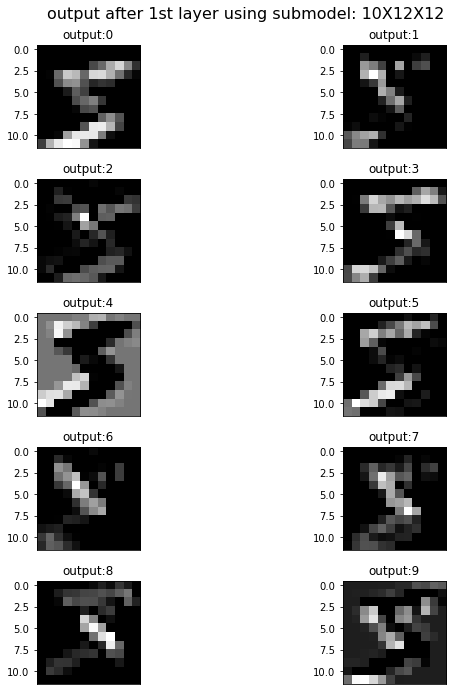

In [13]:
# 2. load the state dictionary you read from the file. 
subnetwork1 = Submodel1()
Note1FG.load_network_state(subnetwork1)
outputSub = Note1FG.run_network(subnetwork1, img)
print(outputSub.shape)


# 3. plot the ouput after running the sub network
size_r= 10
size_c = 10

figure = plt.figure(figsize=(size_r, size_c))
figure.suptitle("output after 1st layer using submodel: 10X12X12", fontsize=16)

for i in range(len(outputSub)):
    
    # - set the fig
    plt.subplot(5, 2, i+1)
    plt.tight_layout()
    plt.title("output:%d" %(i))
    plt.imshow(outputSub[i], cmap = 'gray', interpolation='none')

    # - remove x, y values
    plt.xticks([])

In [14]:
# Question: Double-check that these look like filtered versions of the input image.
# how come it looks nothing like the filtered version? Doe it actually make sense ?

# TODO: create main and function for each section

